## **Pixels to Purchasing Power – Predicting Cost of Living Using Vision + Economic Signals**

**Problem Statement:**
Traditional economic forecasting often relies purely on numerical data like income, inflation, or region. However, lifestyle patterns—visible through the objects people use—can signal socioeconomic tiers that aren’t captured in numbers alone.

**This project explores:**
Can we predict the cost of living in a country by combining lifestyle cues (from images) with structured economic data?

**Use Case:**
1. We simulate real-world economic profiling by merging:
2. Lifestyle images (e.g., books, chairs, laptops) → classified into tech tiers (low, mid, high)
3. Country-level economic data → income index, region, cost of living

**By doing this, we build a hybrid AI system that:**

- Classifies lifestyle indicators using a CNN
- Maps them to economic tiers
- Engineers features like income lag, region, and cost ratios
- Predicts cost of living using advanced regression models
- Serves predictions via a REST API and Streamlit app

This approach demonstrates how vision data can enrich economic forecasting, with applications in policy design, market segmentation, and consumer affordability modeling.

This end-to-end ML system predicts a country’s cost of living using a combination of visual lifestyle patterns (from image classification) and real economic indicators (from DSP-style datasets). It simulates how shifts in lifestyle — like adopting more tech-based habits — can impact economic burden.

# Install dependencies

In [1]:
!pip install opencv-python tensorflow scikit-learn seaborn matplotlib xgboost --quiet
!pip install fastapi uvicorn[standard] joblib
!pip install streamlit


# Importing Required Libraries

In [2]:
# Core libraries
import os
import cv2
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

# TensorFlow / CNN modules
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Scikit-learn tools
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge, Lasso
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from scipy.stats import zscore
from lightgbm import LGBMRegressor
from sklearn.svm import SVR

# MLOps & App interfaces
from fastapi import FastAPI
from pydantic import BaseModel
import streamlit as st


import streamlit as st
import joblib
from pyngrok import ngrok
import time

# Mount Google Drive and Define File Paths

In [3]:
# Mount Google Drive for file access
from google.colab import drive
drive.mount('/content/drive')

# Base directory path inside Google Drive
base_dir = "/content/drive/MyDrive/data/"

# Paths to image dataset folders
train_dir = os.path.join(base_dir, "train")
val_dir = os.path.join(base_dir, "val")
test_dir = os.path.join(base_dir, "test")

# Path to economic CSV data
econ_path = os.path.join(base_dir, "Cost_of_Living_and_Income.csv")

# Output folder to save models and encoders
output_dir = os.path.join(base_dir, "outputs")
os.makedirs(output_dir, exist_ok=True)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Set Image Size and Load Data using ImageDataGenerator

In [4]:
# Define image size and batch size for CNN training
img_size = (100, 100)
batch_size = 32

# Initialize ImageDataGenerator with rescaling
datagen = ImageDataGenerator(rescale=1.0 / 255)

# Load training images from directory
train_gen = datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

# Load validation images from directory
val_gen = datagen.flow_from_directory(
    val_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

# Extract the class labels (e.g., 'book', 'chair', 'laptop')
class_names = list(train_gen.class_indices.keys())


Found 747 images belonging to 3 classes.
Found 254 images belonging to 3 classes.


# Define and Train CNN Model for Vision Classification

In [5]:
# Build CNN model using Keras Sequential API
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(100, 100, 3)),
    MaxPooling2D(),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(train_gen.num_classes, activation='softmax')  # Output layer: number of classes
])

# Compile the model with Adam optimizer and categorical cross-entropy loss
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Set callbacks to stop early and save best model
checkpoint = ModelCheckpoint(
    os.path.join(output_dir, "cnn_model.h5"),
    save_best_only=True,
    monitor='val_loss'
)
early_stop = EarlyStopping(
    patience=3,
    restore_best_weights=True
)

# Train the CNN model on training data with validation
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=10,
    callbacks=[checkpoint, early_stop]
)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step - accuracy: 0.3631 - loss: 1.3048

24/24 ━━━━━━━━━━━━━━━━━━━━ 23s 634ms/step - accuracy: 0.3647 - loss: 1.2991 - val_accuracy: 0.6063 - val_loss: 0.9104
Epoch 2/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 0.5951 - loss: 0.9241

24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 165ms/step - accuracy: 0.5958 - loss: 0.9233 - val_accuracy: 0.6575 - val_loss: 0.8123
Epoch 3/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - accuracy: 0.7391 - loss: 0.7266

24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 155ms/step - accuracy: 0.7387 - loss: 0.7267 - val_accuracy: 0.7598 - val_loss: 0.6611
Epoch 4/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 149ms/step - accuracy: 0.7670 - loss: 0.5878 - val_accuracy: 0.7047 - val_loss: 0.7283
Epoch 5/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 200ms/step - accuracy: 0.8645 - loss: 0.4557 - val_accuracy: 0.7047 - val_loss: 0.7263
Epoch 6/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - accuracy: 0.8814 - loss: 0.3346

24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 198ms/step - accuracy: 0.8814 - loss: 0.3338 - val_accuracy: 0.7953 - val_loss: 0.6530
Epoch 7/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 146ms/step - accuracy: 0.9251 - loss: 0.2472 - val_accuracy: 0.7205 - val_loss: 0.8024
Epoch 8/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 161ms/step - accuracy: 0.9669 - loss: 0.1217 - val_accuracy: 0.7362 - val_loss: 0.7864
Epoch 9/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 182ms/step - accuracy: 0.9786 - loss: 0.0802 - val_accuracy: 0.7717 - val_loss: 0.8102


# Predict Test Images and Create Vision Category DataFrame

In [6]:
# Load test images (unlabeled) for inference
test_gen = datagen.flow_from_directory(
    test_dir,
    target_size=img_size,
    batch_size=1,
    class_mode=None,
    shuffle=False
)

# Run predictions using the trained CNN model
preds = model.predict(test_gen)
pred_classes = np.argmax(preds, axis=1)  # Get predicted class indices

# Map index back to class names using the train generator mapping
index_to_label = {v: k for k, v in train_gen.class_indices.items()}
pred_labels = [index_to_label[i] for i in pred_classes]

# Build a DataFrame of test image names and predicted categories
df_vision = pd.DataFrame({
    'image_name': [os.path.basename(f) for f in test_gen.filenames],
    'vision_category': pred_labels
})

# Add encoded numeric category (e.g., book → 0, chair → 1, laptop → 2)
df_vision['vision_code'] = LabelEncoder().fit_transform(df_vision['vision_category'])


Found 615 images belonging to 3 classes.
615/615 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step


# Load Economic Data and Simulate Merge with Vision Categories

In [7]:
# Load and rename economic data columns for consistency
df_econ = pd.read_csv(econ_path)
df_econ = df_econ.rename(columns={
    'Country': 'country_name',
    'Average_Monthly_Income': 'income_index',
    'Cost_of_Living': 'cost_of_living_index',
    'Region': 'urbanization_score'
})

# Clean dataset: drop missing values and reset index
df_econ.dropna(inplace=True)
df_econ.reset_index(drop=True, inplace=True)

# Split data into income tiers based on quantiles
high = df_econ[df_econ['income_index'] >= df_econ['income_index'].quantile(0.66)]
mid  = df_econ[(df_econ['income_index'] < df_econ['income_index'].quantile(0.66)) &
               (df_econ['income_index'] >= df_econ['income_index'].quantile(0.33))]
low  = df_econ[df_econ['income_index'] < df_econ['income_index'].quantile(0.33)]

# Merge vision labels with economic data by aligning rows in each income tier
def simulate_merge(cat_df, econ_df):
    n = min(len(cat_df), len(econ_df))
    return pd.concat([
        cat_df.iloc[:n].reset_index(drop=True),
        econ_df.iloc[:n].reset_index(drop=True)
    ], axis=1)

# Combine all merged segments into one dataset
df_final = pd.concat([
    simulate_merge(df_vision[df_vision['vision_category'] == 'laptop'], high),
    simulate_merge(df_vision[df_vision['vision_category'] == 'chair'], mid),
    simulate_merge(df_vision[df_vision['vision_category'] == 'book'], low)
]).reset_index(drop=True)


# Feature Engineering and Train-Test Split

In [8]:
# Encode the region column into numeric format
le_region = LabelEncoder()
df_final['urbanization_code'] = le_region.fit_transform(df_final['urbanization_score'])

# Engineer additional features
df_final['cost_to_income'] = df_final['cost_of_living_index'] / df_final['income_index']
df_final['region_income_mean'] = df_final.groupby('urbanization_code')['income_index'].transform('mean')

# Define input features for model
features = [
    'income_index',
    'vision_code',
    'urbanization_code',
    'cost_to_income',
    'region_income_mean'
]

# Define prediction target
target = 'cost_of_living_index'

# Split data into input and target
X = df_final[features]
y = df_final[target]

# Split into training and testing datasets (80/20)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


# Train and Evaluate Regression Models

In [9]:
# Define candidate regression models
models = {
    'RandomForest': RandomForestRegressor(n_estimators=100, random_state=42),
    'XGBoost': XGBRegressor(n_estimators=100, random_state=42)
}

# Initialize list to collect evaluation results
results = []

# Train each model and evaluate on test data
for name, model in models.items():
    model.fit(X_train, y_train)  # Train the model
    preds = model.predict(X_test)  # Predict on test set

    # Compute evaluation metrics
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    r2 = r2_score(y_test, preds)

    # Store results
    results.append({'Model': name, 'RMSE': rmse, 'R2 Score': r2})

    # Display result
    print(f"{name} → R²: {r2:.4f}, RMSE: {rmse:.2f}")


RandomForest → R²: 0.9768, RMSE: 279.86
XGBoost → R²: 0.9716, RMSE: 309.57


# Visualisation

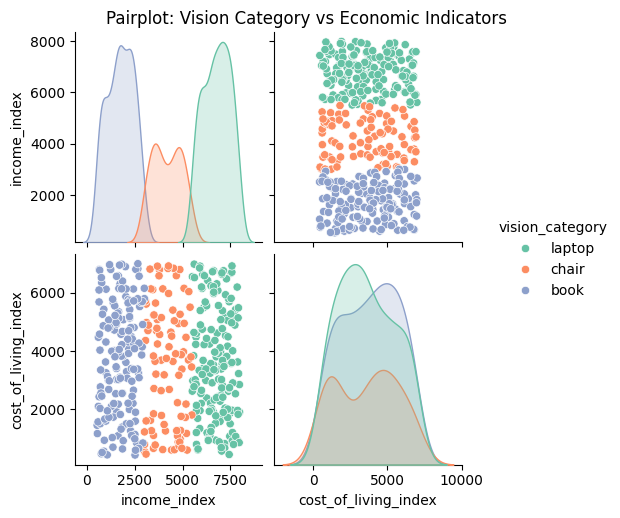

In [10]:
# Pairplot of Economic Indicators by Vision Category (Income vs cost of living vs category)
sns.pairplot(df_final, vars=['income_index', 'cost_of_living_index'],
             hue='vision_category', palette='Set2')
plt.suptitle("Pairplot: Vision Category vs Economic Indicators", y=1.02)
plt.show()


<ipython-input-11-4342bda527b6>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_final, x='vision_category', palette='pastel')


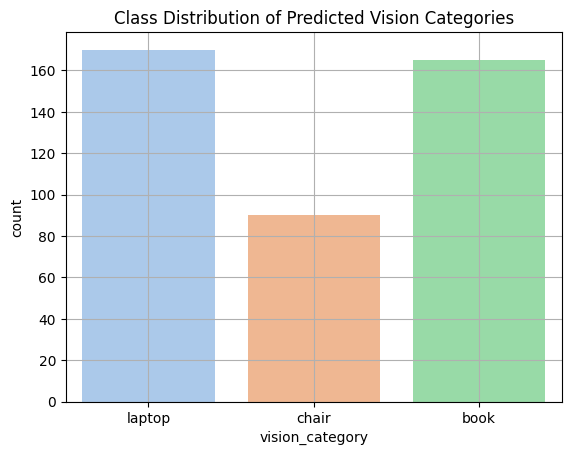

In [11]:
# Count Plot of Vision Categories (How many images per lifestyle group?)
sns.countplot(data=df_final, x='vision_category', palette='pastel')
plt.title("Class Distribution of Predicted Vision Categories")
plt.grid(True)
plt.show()


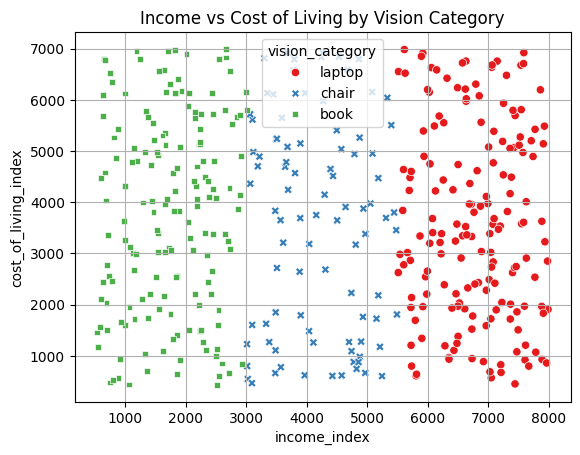

In [12]:
# Scatter Plot: Income vs Cost of Living (Colored by Category)
sns.scatterplot(data=df_final, x='income_index', y='cost_of_living_index',
                hue='vision_category', style='vision_category', palette='Set1')
plt.title("Income vs Cost of Living by Vision Category")
plt.grid(True)
plt.show()


<ipython-input-13-2833bf72c622>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(data=df_final, x='vision_category', y='cost_of_living_index',


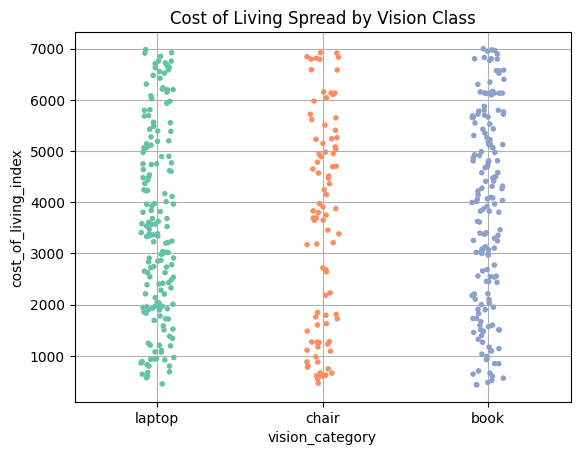

In [13]:
# Swarm Plot or Strip Plot (Category vs Cost)
sns.stripplot(data=df_final, x='vision_category', y='cost_of_living_index',
              jitter=True, size=4, palette='Set2')
plt.title("Cost of Living Spread by Vision Class")
plt.grid(True)
plt.show()


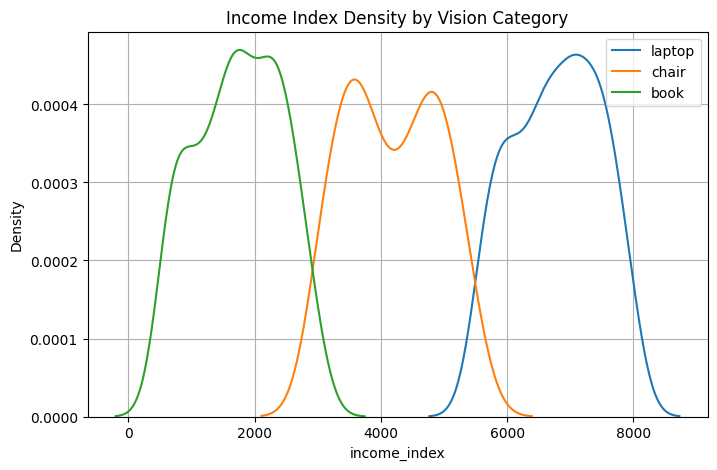

In [14]:
# KDE Plot: Income Density per Vision Category
plt.figure(figsize=(8, 5))
for cat in df_final['vision_category'].unique():
    sns.kdeplot(df_final[df_final['vision_category'] == cat]['income_index'], label=cat)

plt.title("Income Index Density by Vision Category")
plt.legend()
plt.grid(True)
plt.show()


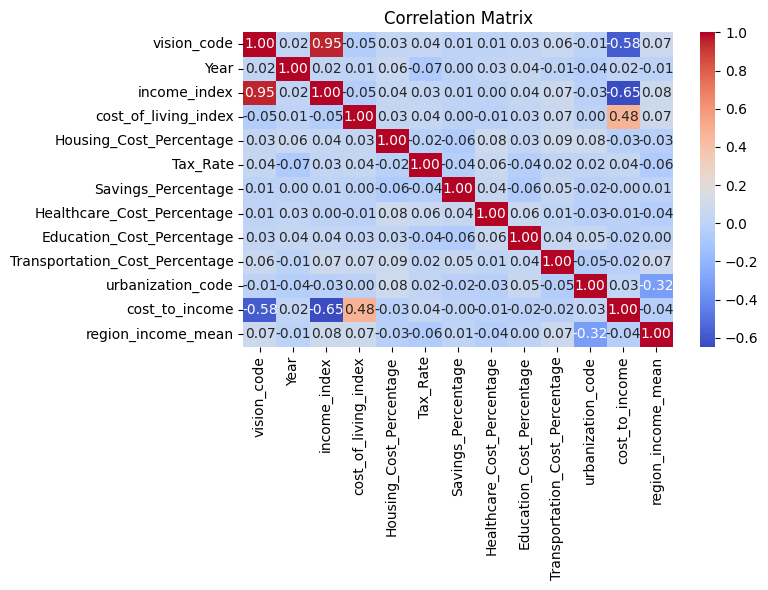

In [15]:
# Correlation heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(df_final.corr(numeric_only=True), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix")
plt.tight_layout()
plt.show()


# Simulated time-series features (rolling, lag)

In [16]:
# Compute 5-period rolling mean for income
df_final['income_rolling'] = df_final['income_index'].rolling(window=5, min_periods=1).mean()

# Create lagged cost feature (shift by 1)
df_final['cost_lag1'] = df_final['cost_of_living_index'].shift(1).bfill()

# Reset index to maintain consistency
df_final.reset_index(drop=True, inplace=True)

# Preview updated DataFrame
df_final.head()


,image_name,vision_category,vision_code,country_name,Year,income_index,cost_of_living_index,Housing_Cost_Percentage,Tax_Rate,Savings_Percentage,Healthcare_Cost_Percentage,Education_Cost_Percentage,Transportation_Cost_Percentage,urbanization_score,urbanization_code,cost_to_income,region_income_mean,income_rolling,cost_lag1
0,0B86Y6FVRC1P.jpg,laptop,2,India,2019,7771.03,5422.78,25.21,29.30,3.35,17.21,12.42,9.90,Asia,1,0.697820,4390.342903,7771.030000,5422.78
1,0X9P572S6CIS.jpg,laptop,2,Russia,2004,6991.30,3972.36,40.85,22.94,15.48,15.28,7.10,9.59,Europe,2,0.568186,4161.462333,7381.165000,5422.78
2,1TTYES3CSI47.jpg,laptop,2,South Africa,2011,6628.04,6755.75,30.38,15.69,8.03,6.66,11.76,11.04,Africa,0,1.019268,4639.251282,7130.123333,3972.36
3,397ZE2QO6PX1.jpg,laptop,2,China,2020,5514.82,6551.39,44.67,15.64,11.37,8.75,5.08,9.73,Asia,1,1.187961,4390.342903,6726.297500,6755.75
4,4GXHMZTOUJZ3.jpg,laptop,2,Japan,2006,7470.32,1076.56,23.98,27.86,10.12,12.73,10.81,7.00,Asia,1,0.144112,4390.342903,6875.102000,6551.39


# **Advanced Forecasting Techniques**

# Train Model with Log-Transformed Target

In [17]:
# Apply natural log (log1p) to the target variable to reduce skew
y_train_log = np.log1p(y_train)
y_test_log = np.log1p(y_test)

# Train a RandomForestRegressor on the log-transformed target
rf_log = RandomForestRegressor(n_estimators=100, random_state=42)
rf_log.fit(X_train, y_train_log)

# Predict and inverse transform the predictions back to original scale
pred_log = rf_log.predict(X_test)
pred_inverse = np.expm1(pred_log)

# Evaluate performance on original scale
print("Log-Transformed R²:", r2_score(y_test, pred_inverse))
print("Log-Transformed RMSE:", np.sqrt(mean_squared_error(y_test, pred_inverse)))


Log-Transformed R²: 0.978123779229339
Log-Transformed RMSE: 271.5404752362917


# Ensemble

In [18]:
# Re-train models on original (non-log) target
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

xgb = XGBRegressor(n_estimators=100, random_state=42)
xgb.fit(X_train, y_train)

ridge = Ridge(alpha=1.0)
ridge.fit(X_train, y_train)

# Generate predictions from each model
rf_preds = rf.predict(X_test)
xgb_preds = xgb.predict(X_test)
ridge_preds = ridge.predict(X_test)

# Average predictions (simple ensemble)
ensemble_preds = (rf_preds + xgb_preds + ridge_preds) / 3

# Evaluate ensemble performance
from sklearn.metrics import r2_score, mean_squared_error
print("Ensemble R²:", r2_score(y_test, ensemble_preds))
print("Ensemble RMSE:", np.sqrt(mean_squared_error(y_test, ensemble_preds)))


Ensemble R²: 0.9216582773393983
Ensemble RMSE: 513.8602022575477


# Forecast Scenario: Shift in Vision Category


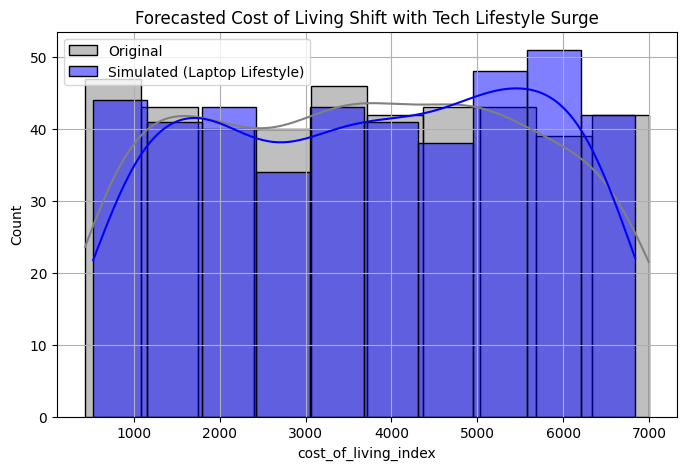

In [19]:
# Get the numeric code for the 'laptop' vision category
vision_code_laptop = df_final[df_final['vision_category'] == 'laptop']['vision_code'].unique()[0]

# Create a copy of the dataset and simulate all users adopting a laptop lifestyle
df_sim = df_final.copy()
df_sim['vision_code'] = vision_code_laptop  # set all to high-tech vision code

# Predict cost of living under simulated conditions
sim_preds = rf.predict(df_sim[features])
df_sim['predicted_cost'] = sim_preds

# Visualize the distribution of original vs simulated predicted cost of living
plt.figure(figsize=(8, 5))
sns.histplot(df_final['cost_of_living_index'], label='Original', color='gray', kde=True)
sns.histplot(df_sim['predicted_cost'], label='Simulated (Laptop Lifestyle)', color='blue', kde=True)
plt.title("Forecasted Cost of Living Shift with Tech Lifestyle Surge")
plt.legend()
plt.grid(True)
plt.show()


# Define Cross-Validation Evaluation Function

In [20]:
from sklearn.model_selection import cross_val_score, KFold

def evaluate_model_cv(model, X, y, name):
    # Set up 5-fold cross-validation with shuffle
    kf = KFold(n_splits=5, shuffle=True, random_state=42)

    # Cross-validate R² score
    r2_scores = cross_val_score(model, X, y, cv=kf, scoring='r2')

    # Cross-validate RMSE (scoring returns negative RMSE, so invert)
    rmse_scores = -cross_val_score(model, X, y, cv=kf, scoring='neg_root_mean_squared_error')

    return {
        'Model': name,
        'CV R2 Mean': r2_scores.mean(),
        'CV R2 Std': r2_scores.std(),
        'CV RMSE Mean': rmse_scores.mean(),
        'CV RMSE Std': rmse_scores.std()
    }


# Run Cross-Validation on Models

In [21]:
# List to store CV evaluation results
cv_results = []

# Dictionary of final candidate models (already trained)
models = {
    'RandomForest': rf,
    'XGBoost': xgb
}

# Run 5-fold cross-validation and collect results
for name, model in models.items():
    result = evaluate_model_cv(model, X, y, name)
    cv_results.append(result)

# Convert results to DataFrame for easy viewing
cv_df = pd.DataFrame(cv_results)

# Sort models by average R² score (descending)
cv_df.sort_values(by='CV R2 Mean', ascending=False)


,Model,CV R2 Mean,CV R2 Std,CV RMSE Mean,CV RMSE Std
1,XGBoost,0.973183,0.005570,311.066333,35.154814
0,RandomForest,0.972889,0.006481,312.553951,41.557819


# Visualize CV Stability

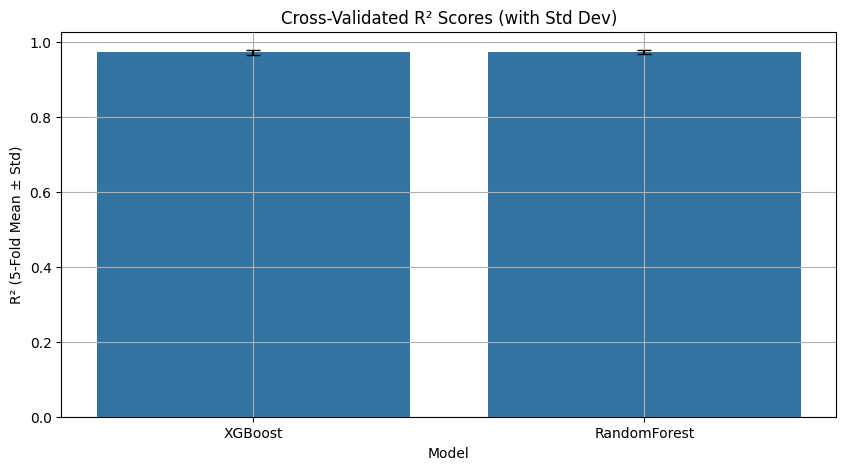

In [22]:
plt.figure(figsize=(10, 5))
sns.barplot(data=cv_df.sort_values(by='CV R2 Mean', ascending=False), x='Model', y='CV R2 Mean')
plt.errorbar(x=range(len(cv_df)), y=cv_df['CV R2 Mean'], yerr=cv_df['CV R2 Std'], fmt='none', c='black', capsize=5)
plt.title("Cross-Validated R² Scores (with Std Dev)")
plt.ylabel("R² (5-Fold Mean ± Std)")
plt.grid(True)
plt.show()


# Save Trained Model (.pkl)


In [23]:
# Define file path for saving the best model
best_model_path = os.path.join(output_dir, "best_rf_model.pkl")

# Serialize the trained RandomForest model
joblib.dump(rf, best_model_path)

# Confirmation
print("Model saved to:", best_model_path)


Model saved to: /content/drive/MyDrive/data/outputs/best_rf_model.pkl


# Save Label Encoders for Future Use

In [24]:
# Rebuild and fit vision encoder
le_vision = LabelEncoder()
le_vision.fit(df_final['vision_category'])

# Rebuild and fit region encoder
le_region = LabelEncoder()
le_region.fit(df_final['urbanization_score'])

# Save the encoders to disk
le_vision_path = os.path.join(output_dir, "le_vision.pkl")
joblib.dump(le_vision, le_vision_path)

le_region_path = os.path.join(output_dir, "le_region.pkl")
joblib.dump(le_region, le_region_path)


['/content/drive/MyDrive/data/outputs/le_region.pkl']

# Reload & Predict

In [25]:
# Load model and encoders from disk
loaded_model = joblib.load(best_model_path)
le_vision_loaded = joblib.load(le_vision_path)
le_region_loaded = joblib.load(le_region_path)

# Run prediction on a sample input
sample_input = X_test.iloc[[0]]
predicted_cost = loaded_model.predict(sample_input)[0]

# Output prediction
print("Predicted cost of living for sample:", predicted_cost)


Predicted cost of living for sample: 1185.845099999999


# Streamlit UI: Cost of Living Prediction Interface

In [30]:
%%writefile app.py
import streamlit as st
import pandas as pd
import joblib

# Load model and encoders
model = joblib.load("/content/drive/MyDrive/data/outputs/best_rf_model.pkl")
le_vision = joblib.load("/content/drive/MyDrive/data/outputs/le_vision.pkl")
le_region = joblib.load("/content/drive/MyDrive/data/outputs/le_region.pkl")

st.set_page_config(page_title="Cost of Living Predictor", layout="centered")
st.title("Predict Cost of Living")

income = st.slider("Income Index", 1000.0, 10000.0, 4500.0)
vision_cat = st.selectbox("Vision Category", le_vision.classes_)
urban_score = st.selectbox("Region", le_region.classes_)
cost_lag = st.slider("Last Month's Cost (Lag)", 500.0, 9000.0, 2800.0)
income_roll = st.slider("Rolling Avg Income", 1000.0, 10000.0, 4400.0)

if st.button("Predict"):
    vision_code = le_vision.transform([vision_cat])[0]
    urban_code = le_region.transform([urban_score])[0]

    X = pd.DataFrame([{
        "income_index": income,
        "vision_code": vision_code,
        "urbanization_code": urban_code,
        "cost_lag1": cost_lag,
        "income_rolling": income_roll
    }])

    pred = model.predict(X)[0]
    st.success(f"Estimated Cost of Living: ₹{round(pred, 2)}")


Overwriting app.py


In [32]:
!cp app.py /content/drive/MyDrive/data/outputs/


# Model Prediction Logic

In [33]:
# Kill old tunnels
ngrok.kill()
ngrok.set_auth_token("2e4uMmmZy2ANy4jLUPNWyUgRzRj_6uXVkuMTqZNUMzm8Nrmyp")

# Launch Streamlit
os.system("streamlit run app.py &")
time.sleep(5)

# Tunnel it
public_url = ngrok.connect(8501)
print(" Streamlit is live at:", public_url)


 Streamlit is live at: NgrokTunnel: "https://45f5-34-125-16-181.ngrok-free.app" -> "http://localhost:8501"
